In [53]:
import polars as pl
import numpy as np 

import pandas as pd  

import matplotlib.pyplot as plt 
import seaborn as sns

import statsmodels.formula.api as smf

In [134]:
# Simulate data
n = 10
t = 20

df = (
    pd.DataFrame(
        {
            "t": np.tile(np.arange(t), n),
            "unit_id": np.repeat(np.arange(n), t),
        }
    )
    .merge(
        pd.DataFrame(
            {
                "unit_id": np.arange(n),
                "cohort": [t + 1 for _ in range(5)]
                + [5 for _ in range(2)]
                + [13 for _ in range(3)],
            }
        ),
        on="unit_id",
        how="inner",
    )
    .assign(
        **{
#            "tau": lambda d: (d["t"] >= d["cohort"])
#            * ((d["cohort"] * 0.2) + (d["t"] - d["cohort"]) * 0.1),
            "tau": lambda d: (d["t"] >= d["cohort"]) * ((d["t"] - d["cohort"]) * 0.1 + 0.3),
#            "tau": lambda d: (d["t"] >= d["cohort"]) * .3,
            "alpha": np.repeat(np.random.uniform(5, 15, n), t),
            "treat": lambda d: (d["t"] >= d["cohort"]),
        }
    )
    .assign(**{"y": lambda d: d["alpha"] + d["tau"]})
)

df.head()

,t,unit_id,cohort,tau,alpha,treat,y
0,0,0,21,-0.0,10.517099,False,10.517099
1,1,0,21,-0.0,10.517099,False,10.517099
2,2,0,21,-0.0,10.517099,False,10.517099
3,3,0,21,-0.0,10.517099,False,10.517099
4,4,0,21,-0.0,10.517099,False,10.517099


In [135]:
df_agg = df.groupby(["cohort", "t"]).agg({
    "alpha": "mean",
    "tau": "mean", 
    "treat": "min",
    "y": "mean",
}).reset_index()

df_agg.head()

,cohort,t,alpha,tau,treat,y
0,5,0,8.077641,0.0,False,8.077641
1,5,1,8.077641,0.0,False,8.077641
2,5,2,8.077641,0.0,False,8.077641
3,5,3,8.077641,0.0,False,8.077641
4,5,4,8.077641,0.0,False,8.077641


<Axes: xlabel='t', ylabel='y'>

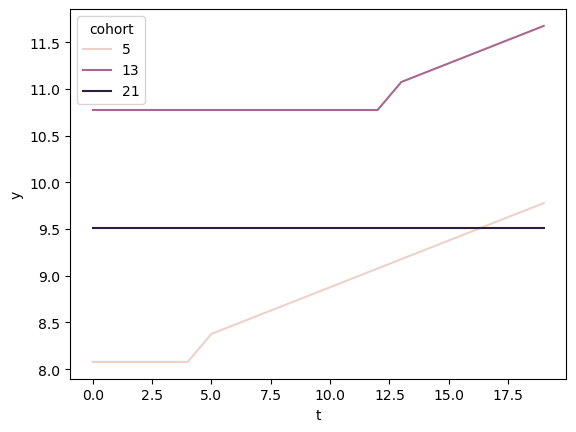

In [136]:
# True effect is going to be tau at any point
sns.lineplot(df_agg, x="t", y="y", hue="cohort")

In [137]:
# Average effects
df_agg.groupby(["cohort"]).apply(lambda d: np.sum((d["treat"]) * d["tau"])/np.sum(d["treat"]))

/tmp/ipykernel_108684/710555239.py:2: RuntimeWarning: invalid value encountered in scalar divide
  df_agg.groupby(["cohort"]).apply(lambda d: np.sum((d["treat"]) * d["tau"])/np.sum(d["treat"]))


cohort
5     1.0
13    0.6
21    NaN
dtype: float64

In [138]:
np.sum((df["t"] >= df["cohort"]) * df["tau"])/np.sum(df["treat"])

0.835294117647059

In [139]:
ols1 = smf.ols("y ~ C(treat, Treatment(reference=False)) + C(t) + C(unit_id)", data=df).fit()

ols1.params.head(2)

Intercept                                       10.462785
C(treat, Treatment(reference=False))[T.True]     0.622297
dtype: float64

In [140]:
ols2 = smf.ols("y ~ treat*C(t)*C(cohort) + C(t) + C(unit_id)", data=df).fit()

In [141]:
df_pred = df.assign(**{
    "hat_0": ols2.predict(df.assign(**{"treat": 0})),
    "hat_1": ols2.predict(df.assign(**{"treat": 1})),
})

df_pred.query("treat==1")["hat_1"].mean() - df_pred.query("treat==1")["hat_0"].mean()

0.7753688141923316

In [142]:
df_pred.query("treat==1 & cohort==5")["hat_1"].mean() - df_pred.query("treat==1 & cohort==5")["hat_0"].mean()

0.9539047619047434

In [143]:
df = df.assign(
    **{"time_since_treat": lambda d: d["treat"] * (d["t"] - d["cohort"] + 1)}
)

In [144]:
ols3 = smf.ols("y ~ C(time_since_treat) + C(t) + C(unit_id)", data=df).fit()

In [145]:
df_pred = df.assign(**{
    "hat_0": ols3.predict(df.assign(**{"time_since_treat": 0})),
    "hat_1": ols3.predict(df),
})

(df_pred.query("treat==1")["hat_1"] - df_pred.query("treat==1")["hat_0"]).mean()

0.8352941176470591

In [146]:
df.head()

,t,unit_id,cohort,tau,alpha,treat,y,time_since_treat
0,0,0,21,-0.0,10.517099,False,10.517099,0
1,1,0,21,-0.0,10.517099,False,10.517099,0
2,2,0,21,-0.0,10.517099,False,10.517099,0
3,3,0,21,-0.0,10.517099,False,10.517099,0
4,4,0,21,-0.0,10.517099,False,10.517099,0


In [147]:
# I want cohort*treat*time specific effects
df["treat_cohort_t"] = df[["treat", "cohort", "t"]].astype(str).apply(lambda d: "_".join(d.values), axis=1)
df["treat_cohort_t"] = df["treat_cohort_t"].apply(lambda x: "C" if x.startswith("False") else x)

df.head()

,t,unit_id,cohort,tau,alpha,treat,y,time_since_treat,treat_cohort_t
0,0,0,21,-0.0,10.517099,False,10.517099,0,C
1,1,0,21,-0.0,10.517099,False,10.517099,0,C
2,2,0,21,-0.0,10.517099,False,10.517099,0,C
3,3,0,21,-0.0,10.517099,False,10.517099,0,C
4,4,0,21,-0.0,10.517099,False,10.517099,0,C


In [148]:
import statsmodels.api as sm

df_exo = pd.concat(
    (
        pd.get_dummies(df["treat_cohort_t"], dtype=int).drop("C", axis=1),
        pd.get_dummies(df[["t", "unit_id"]], columns=["t", "unit_id"], drop_first=True, dtype=int),
    ),
    axis=1,
)

df_exo = sm.add_constant(df_exo)

df_exo.head()

,const,True_13_13,True_13_14,True_13_15,True_13_16,True_13_17,True_13_18,True_13_19,True_5_10,True_5_11,...,t_19,unit_id_1,unit_id_2,unit_id_3,unit_id_4,unit_id_5,unit_id_6,unit_id_7,unit_id_8,unit_id_9
0,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [149]:
df_endo = df["y"]

In [150]:
import statsmodels.api as sm
ols_all = sm.OLS(df_endo, df_exo).fit()

In [151]:
df_counterfactual = df_exo.copy()
df_counterfactual.loc[:, df_counterfactual.columns.str.startswith("True")] = False

# df_treat = df_exo.copy()
# df_treat.loc[:, df_treat.columns.str.startswith("True")] = True


In [152]:
df = df.assign(**{
    "hat_0": ols_all.predict(df_counterfactual),
    "hat_1": ols_all.predict(df_exo)
})

df.query("treat")["hat_1"].mean() - df.query("treat")["hat_0"].mean()

0.8352941176470647

<Axes: xlabel='t', ylabel='hat_1'>

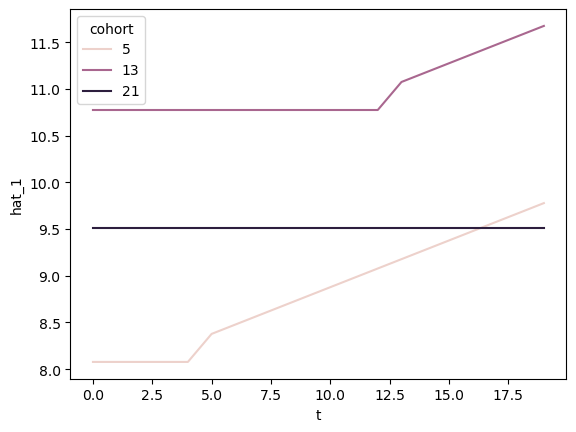

In [153]:
sns.lineplot(
    data=df.groupby(["cohort", "t"]).agg({"hat_1": "mean"}),
    x="t",
    y="hat_1",
    hue="cohort",
)